In [1]:
%load_ext vscode_magic
from math import prod
import numpy as np
from tqdm.notebook import trange, tqdm
from functools import partial
trange = partial(trange, bar_format="{bar}", leave=False)
tqdm = partial(tqdm, bar_format="{bar}", leave=False)

import matplotlib.pyplot as plt
import matplotlib.animation as animation
from matplotlib.animation import FuncAnimation
%matplotlib inline
# %config InlineBackend.figure_format='svg'
%config InlineBackend.figure_format='retina'
import seaborn as sns

# "iridis" color map (viridis without the deep purple)
import matplotlib.colors as colors
import matplotlib.cm

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

iridis = truncate_colormap(plt.get_cmap('viridis'), 0.2, 1)

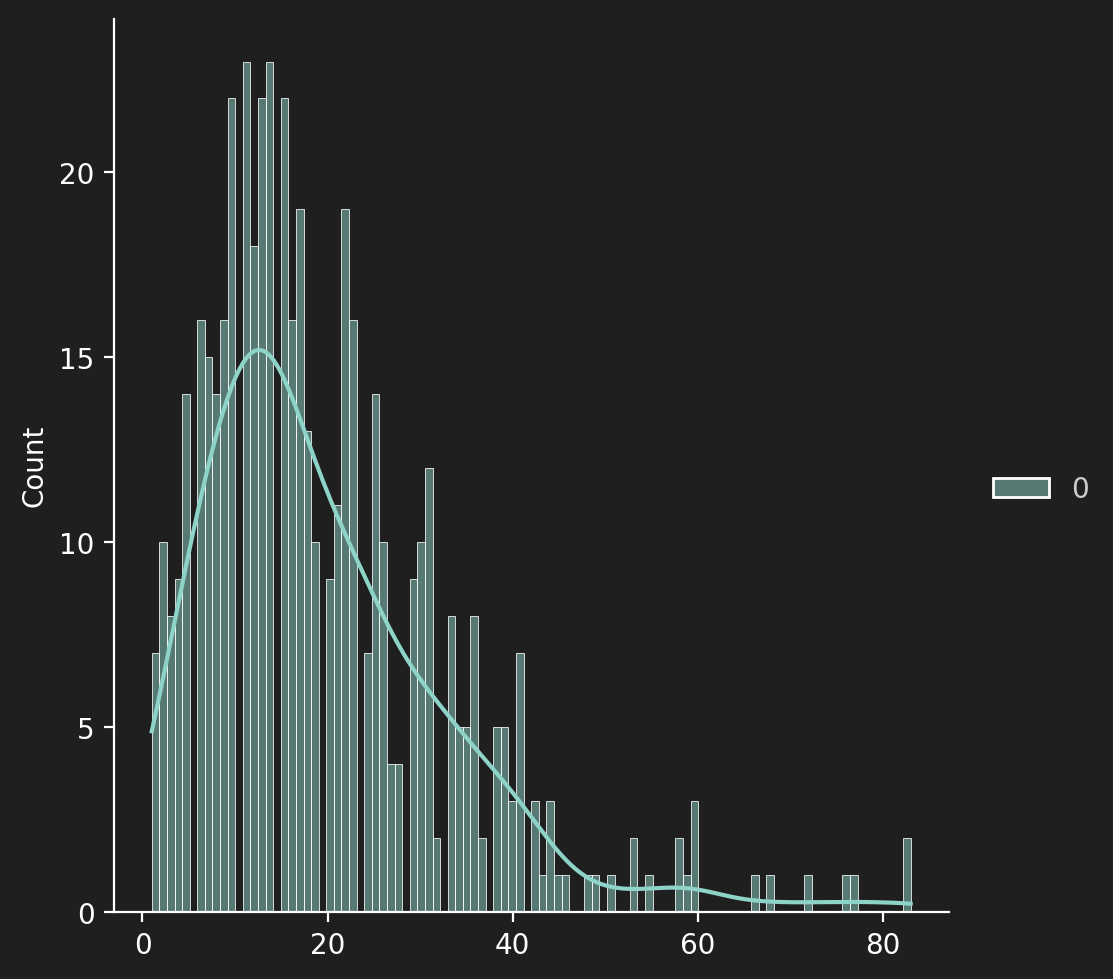

In [4]:
import jax
import jax.numpy as jnp
from jax import grad, vmap
from jax.scipy.stats import norm
import equinox as eqx
import jax.nn as jnn


# Set random seed for reproducibility
_key = jax.random.key(42)

# def simulate_dph_samples(alpha, T, t_vecs, n_samples, key):
def simulate_dph_samples(alpha, T, t_vecs, n_samples, key):
    """
    Simulate multivariate DPH samples using JAX control flow.

    Parameters:
    - alpha: shape (m,) — initial state probabilities
    - T: shape (m, m) — transient transition matrix
    - t_vecs: list of k arrays of shape (m,) — absorption vectors
    - n_samples: number of samples
    - key: jax.random.PRNGKey
    Returns:
    - Array of shape (n_samples, k): time-to-absorption vectors
    """

    m = T.shape[0]

    k = len(t_vecs)
    t_vecs_stacked = jnp.stack(t_vecs, axis=0)  # shape (k, m)

    def single_sample(key):
        key, subkey = jax.random.split(key)
        state = jax.random.choice(subkey, m, p=alpha)
        t_vec = jnp.zeros(k, dtype=int)

        def cond_fn(carry):
            _, _, _, absorbed = carry
            return ~absorbed

        def body_fn(carry):
            key, state, t, _ = carry
            key, *subkeys = jax.random.split(key, num=k + 2)
            draws = jnp.array([
                jax.random.uniform(subkeys[i]) < t_vecs_stacked[i, state]
                for i in range(k)
            ])
            absorbed = jnp.any(draws)
            absorb_idx = jnp.argmax(draws)

            t_new = jax.lax.cond(absorbed, lambda t_: t_, lambda t_: t_ + 1, t)

            state_new = jax.lax.cond(
                absorbed,
                lambda s: s,
                lambda s: jax.random.choice(subkeys[-1], m, p=T[s]),
                operand=state
            )

            return key, state_new, t_new, absorbed

        init_carry = (key, state, jnp.zeros(k, dtype=int), False)
        _, _, t_final, _ = jax.lax.while_loop(cond_fn, body_fn, init_carry)
        return t_final

    keys = jax.random.split(key, n_samples)
    return jax.vmap(single_sample)(keys)

def empirical_copula_transform(X):
    ranks = jnp.argsort(jnp.argsort(X, axis=0), axis=0)
    U = (ranks + 1) / (X.shape[0] + 1)
    return U

def probit_transform(U):
    return norm.ppf(U)

def unpack_theta(theta, m, k):
    """Make this function fully static for JIT compilation"""
    offset = 0
    alpha_logits = jax.lax.dynamic_slice(theta, (offset,), (m,))

    offset += m
    T_logits = jax.lax.dynamic_slice(theta, (offset,), (m * m,)).reshape((m, m))

    offset += m * m
    t_logits_flat = jax.lax.dynamic_slice(theta, (offset,), (k * m,))
    t_logits = t_logits_flat.reshape((k, m))
    
    alpha = jax.nn.softmax(alpha_logits)

    ##################

    T = jax.nn.softmax(T_logits, axis=1)
    t_vecs_array = jax.nn.softmax(t_logits, axis=1)  # shape (k, m)

    ##################

    # Convert to list for compatibility
    t_vecs = [t_vecs_array[i] for i in range(k)]
    
    row_sums = T.sum(axis=1) + jnp.sum(t_vecs_array, axis=0)
    T = T / row_sums[:, None]
    t_vecs = [t / row_sums for t in t_vecs]
    
    return alpha, T, t_vecs

def log_pmf_dph(z, alpha, T, t_vecs):
    """
    Fully static version for JIT compilation
    """
    m = T.shape[0]
    k = len(t_vecs)

    # Use fixed upper bound
    z_max = 50
    t_mat = jnp.stack(t_vecs, axis=1)  # shape (m, k)

    def body_fun(i, carry):
        Tk, probs = carry
        out = alpha @ Tk @ t_mat
        Tk_next = Tk @ T
        return Tk_next, probs.at[i].set(out)

    Tk0 = jnp.eye(m)
    probs_init = jnp.zeros((z_max, k))
    _, probs_filled = jax.lax.fori_loop(0, z_max, body_fun, (Tk0, probs_init))

    # Ensure z is properly shaped and clipped
    z_clipped = jnp.clip(z.astype(int), 0, z_max - 1)
    
    # Use a fully vectorized approach without conditionals
    # Pad z_clipped to always have k elements (for univariate case)
    z_padded = jnp.pad(z_clipped, (0, max(0, k - len(z_clipped))))[:k]
    
    # Use advanced indexing with static shapes
    indices = jnp.arange(k)
    prob_at_z = probs_filled[z_padded, indices]
    logp = jnp.sum(jnp.log(jnp.maximum(prob_at_z, 1e-12)))
    
    return logp

def rbf_kernel(X, h=-1):
    pairwise_dists = jnp.sum((X[:, None, :] - X[None, :, :])**2, axis=-1)
    # Make bandwidth calculation static to avoid dynamic operations
    h = jnp.where(h <= 0, 
                  jnp.median(pairwise_dists) / jnp.log(X.shape[0] + 1.0),
                  h)
    K = jnp.exp(-pairwise_dists / h)
    grad_K = -2 / h * (X[:, None, :] - X[None, :, :]) * K[:, :, None]
    return K, grad_K

class DPHDecoder(eqx.Module):
    m: int
    k: int
    alpha_layer: eqx.nn.Linear
    T_layer: eqx.nn.Linear
    t_layers: list

    def __init__(self, latent_dim, m, k, key):
        self.m = m
        self.k = k
        keys = jax.random.split(key, k + 2)
        self.alpha_layer = eqx.nn.Linear(latent_dim, m, key=keys[0])
        self.T_layer = eqx.nn.Linear(latent_dim, m * m, key=keys[1])
        self.t_layers = [eqx.nn.Linear(latent_dim, m, key=keys[i+2]) for i in range(k)]

    def __call__(self, z):
        alpha_logits = self.alpha_layer(z)
        T_logits = self.T_layer(z).reshape(self.m, self.m)
        t_logits = [layer(z) for layer in self.t_layers]

        alpha = jnn.softmax(alpha_logits)
        T = jnn.softmax(T_logits, axis=1)
        t_vecs = [jnn.softmax(t) for t in t_logits]

        row_sums = T.sum(axis=1) + sum(t_vecs)
        T = T / row_sums[:, None]
        t_vecs = [t / row_sums for t in t_vecs]
        return alpha, T, t_vecs

def svgd_update_z(particles_z, data, m, k, step_size):
    def logp_z(z):
        alpha, T, t_vecs = z_to_theta(z, m, k) 
        
        return jnp.sum(vmap(lambda z_i: log_pmf_dph(z_i, alpha, T, t_vecs))(data))
    grads = vmap(grad(logp_z))(particles_z)
    K, grad_K = rbf_kernel(particles_z)
    phi = (K @ grads + jnp.sum(grad_K, axis=1)) / particles_z.shape[0]
    return particles_z + step_size * phi

# Apply JIT using functional form
svgd_update_z = jax.jit(svgd_update_z, static_argnums=(2, 3))

key = jax.random.key(0)

###### ptd definition
m = 2 # nr states
alpha_true = jnp.array([1.0, 0.0])
T_true = jnp.array([[0.9, 0.1],
                    [0.0, 0.9]])

# number of absorption types (1 for univariate dph, 2 for bivariate)
# univariate dph
t1_true = jnp.array([0.0, 0.1])
abs_rates = [t1_true]  # absorption rates for univariate dph
k = 1  

# # multivariate dph
# t1_true = jnp.array([0.1, 0.3])
# t2_true = jnp.array([0.0, 0.2])
# abs_rates = [t1_true, t2_true]  # absorption rates for univariate dph
# k = 2  # number of absorption types (1 for univariate dph, 2 for bivariate)

###### Simulate
X = simulate_dph_samples(alpha_true, T_true, abs_rates, 500, key)
# X = simulate_dph_samples(alpha_true, 0.2, abs_rates, 5, key)

sns.displot(X, bins=100, kde=True);


In [5]:


####### SVGD setup
# d = m + m * m + k * m  # Fixed dimension calculation
d = m + m * 1 * m  # Fixed dimension calculation
n_particles = 500
step_size = 0.01
n_iter = 100

####### Copula transform
U = empirical_copula_transform(X)
Z_data = probit_transform(U)

decoder = DPHDecoder(latent_dim=d, m=m, k=k, key=jax.random.key(0))

def z_to_theta(z, m, k):
    return unpack_theta(z, m, k)
    # return decoder(z)

####### SVGD fit
key = jax.random.key(1)
# initial_particles_z = jax.random.normal(key, (n_particles, d))
initial_particles_z = jax.random.uniform(key, shape=(n_particles, d), minval=0, maxval=1)

particles_z = initial_particles_z
particle_history = [particles_z]
for i in trange(n_iter):
    particles_z = svgd_update_z(particles_z, X, m, k, step_size)
    particle_history.append(particles_z)


######## Extract particles and compute posterior means for alpha, T, and t_vecs
posterior_params = vmap(lambda z: z_to_theta(z, m, k))(particles_z)
alpha_particles, T_particles, t_vecs_particles = posterior_params
alpha_est = jnp.mean(alpha_particles, axis=0)
T_est = jnp.mean(T_particles, axis=0)
t_vecs_est = [jnp.mean(t_vecs_particles[i], axis=0) for i in range(k)]

print("Estimated α:", alpha_est)
print("Estimated T:\n", T_est)
print("Estimated t_vecs:", t_vecs_est)

# For compatibility with other code, create a particles array
particles = jnp.concatenate([
    alpha_particles,
    T_particles.reshape(n_particles, -1),
    jnp.concatenate([t_vecs_particles[i] for i in range(k)], axis=1)
], axis=1)

Estimated α: [0.55963385 0.44036612]
Estimated T:
 [[0.5196872  0.24845904]
 [0.41532803 0.29233602]]
Estimated t_vecs: [Array([0.23185384, 0.29233602], dtype=float32)]


In [6]:
def logp_z(z):
    theta = z_to_theta(z, m, k)
    alpha, T, t_vecs = unpack_theta(theta, m, k)
    return jnp.sum(vmap(lambda x: log_pmf_dph(x, alpha, T, t_vecs))(X))

def logp(theta):
    alpha, T, t_vecs = unpack_theta(theta, m, k)
    log_prob = jnp.sum(vmap(lambda x: log_pmf_dph(x, alpha, T, t_vecs))(X))
    return log_prob

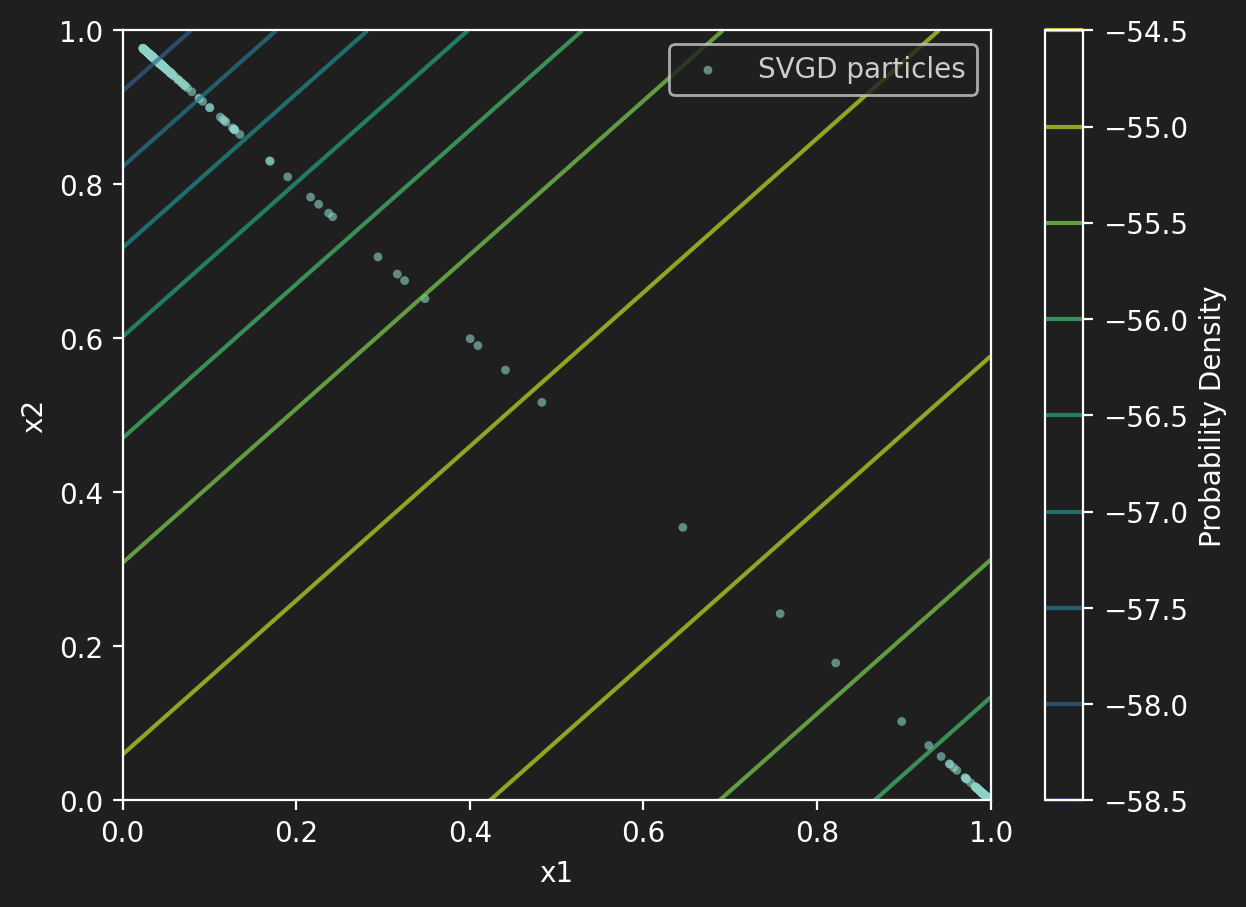

In [7]:
# Visualize results
plt.figure(figsize=(7, 5))

# Plot final particles
plt.scatter(particles[:, 0], particles[:, 1], s=10, alpha=0.6, edgecolor='none', label='SVGD particles')

# Generate contour plot of the target distribution
resolution = 50
x = jnp.linspace(0, 1, resolution)
y = jnp.linspace(0, 1, resolution)
X, Y = jnp.meshgrid(x, y)
pos = jnp.stack([X.flatten(), Y.flatten()], axis=1)
# vmap expects a function that takes a single argument, so wrap log_prob accordingly
# You need to use the correct log probability function for your model.
# In your notebook, the function is named `logp_z`, and it expects a vector of shape (d,)
# But your grid points are 2D, while your model's latent space is higher-dimensional (d=8).
# For visualization, you should select two dimensions (e.g., the first two) and fix the rest.

theta_mean = jnp.mean(particles, axis=0)

# We'll fix the remaining dimensions to their mean values from theta_mean:
def logp_2d(p):
    # p: shape (2,)
    z = theta_mean.at[-2:].set(p)  # replace first two dims with p, keep others fixed
    return logp(z)

# Z = jnp.exp(vmap(logp_2d)(pos)).reshape(X.shape)
Z = vmap(logp_2d)(pos).reshape(X.shape)

plt.contour(X, Y, Z, cmap=iridis, alpha=0.7)
#plt.title('SVGD with JAX: Sampling from a 2D Gaussian')
plt.xlabel('x1')
plt.ylabel('x2')
plt.legend()
# plt.grid(alpha=0.3) 
plt.colorbar(label='Probability Density')

/var/folders/s6/srs8qkh52w1_h32d65z95tth0000gn/T/ipykernel_13021/2543888238.py:27: UserWarning: KDE cannot be estimated (0 variance or perfect covariance). Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(x=final[0][:, idx[0]], y=final[0][:, idx[1]], cmap=iridis)


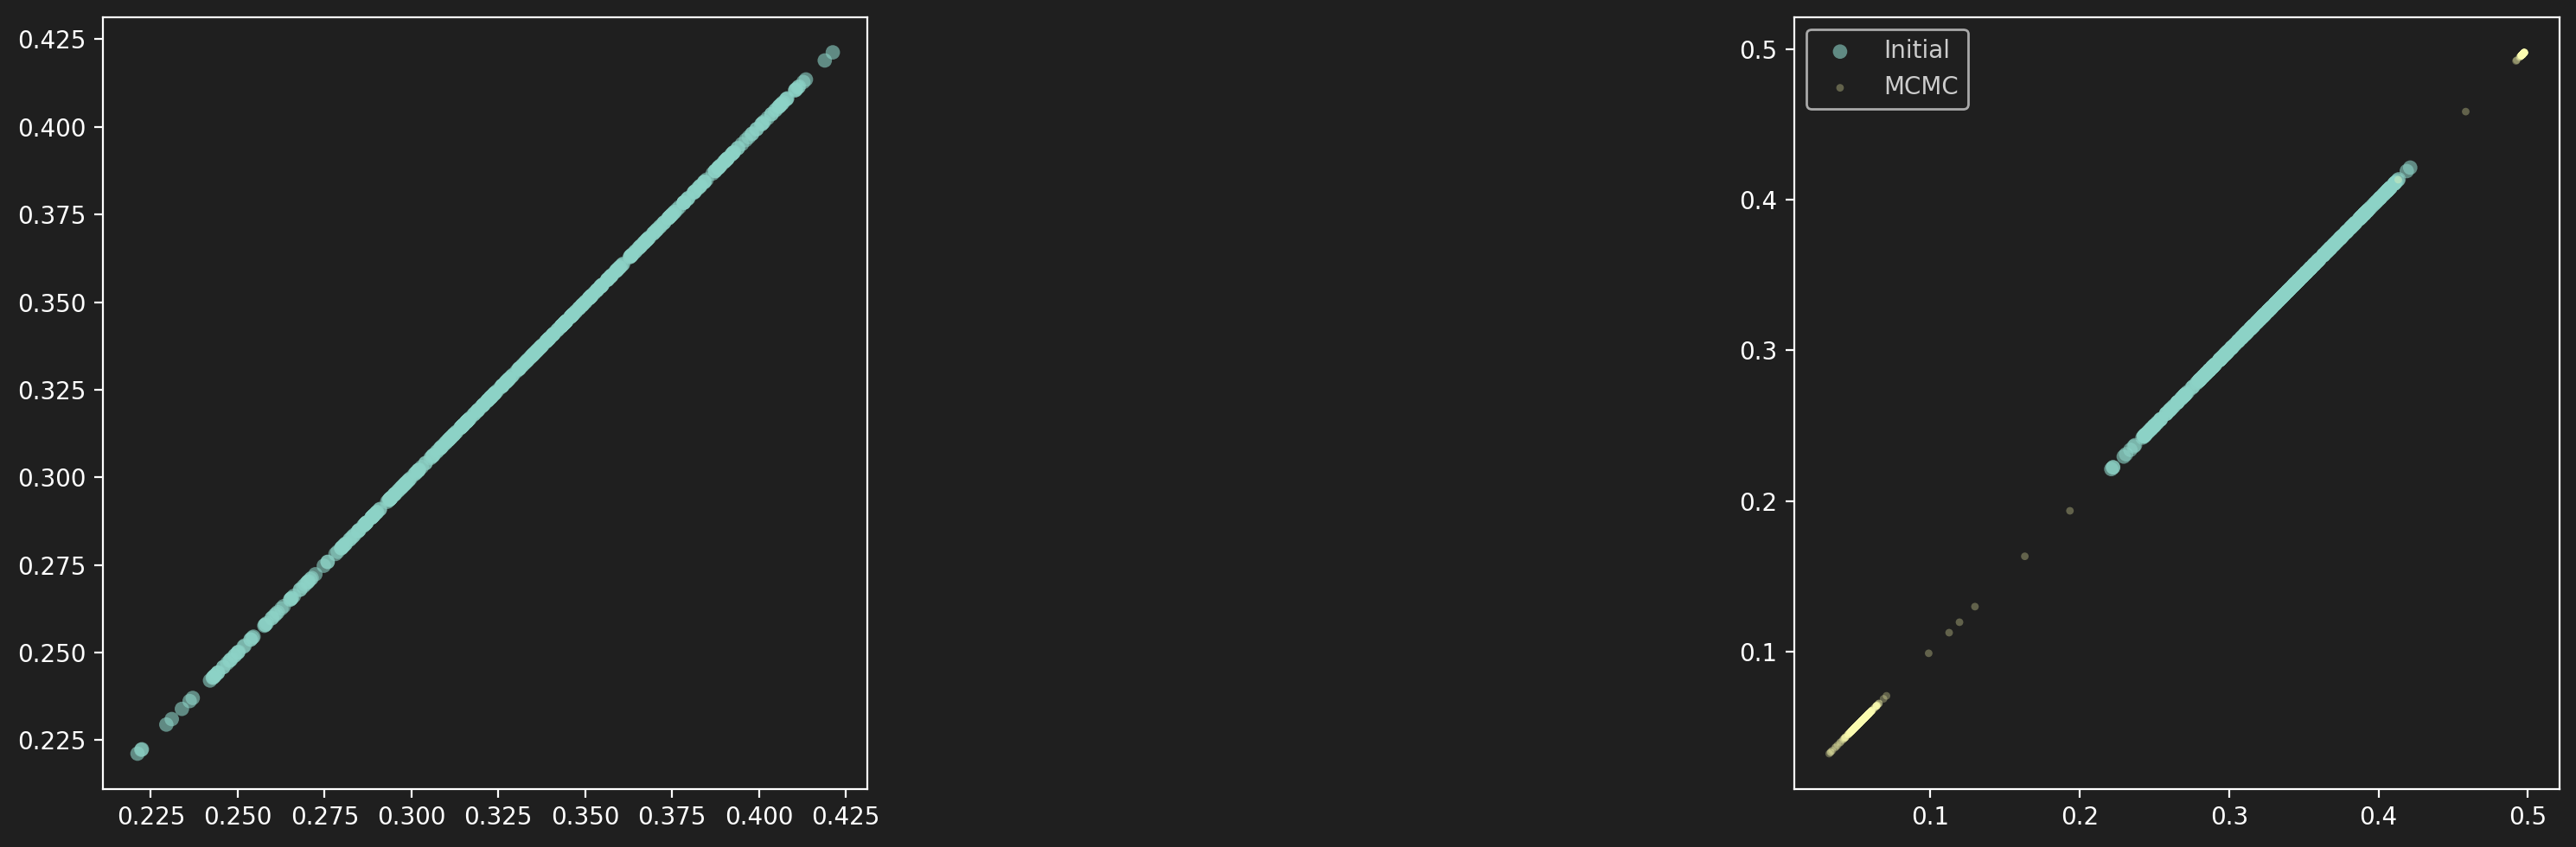

In [8]:
idx = (2, 3)

# Plot results
plt.figure(figsize=(15, 5))

# Plot initial particles
_, _, initial = vmap(lambda z: z_to_theta(z, m, k))(particle_history[0])
plt.subplot(1, 3, 1)
plt.scatter(initial[0][:, idx[0]], initial[0][:,  idx[1]], edgecolor='none', alpha=0.6, label='Initial')
# plt.grid(alpha=0.3)

# # Plot reference samples
# plt.subplot(1, 3, 2)
# # plt.scatter(mcmc_samples[:, 0], mcmc_samples[:, 1], edgecolor='none', alpha=0.3, s=10, label='MCMC')
# sns.scatterplot(x=X[:,  idx[0]], y=X[:,  idx[1]], edgecolor='none', alpha=0.3, s=10, label='MCMC')
# sns.kdeplot(x=X[:,  idx[0]], y=X[:,  idx[1]], cmap=iridis)    
# plt.title('Initial particles')
# plt.title('Samples')
# # plt.grid(alpha=0.3)

# Plot final SVGD particles
plt.subplot(1, 3, 3)
plt.scatter(initial[0][:, idx[0]], initial[0][:, idx[1]], edgecolor='none', alpha=0.6, label='Initial')

_, _, final = vmap(lambda z: z_to_theta(z, m, k))(particle_history[-1])
sns.scatterplot(x=final[0][:, idx[0]], y=final[0][:, idx[1]], edgecolor='none', alpha=0.3, s=10, label='MCMC')
sns.kdeplot(x=final[0][:, idx[0]], y=final[0][:, idx[1]], cmap=iridis)    
# plt.scatter(final_particles[:, 0], final_particles[:, 1], edgecolor='none', alpha=0.6, label='SVGD')
# plt.title('SVGD with Copula Transform')
# plt.grid(alpha=0.3)

plt.tight_layout()

In [10]:
def map_estimate_from_particles(particles, log_prob_fn):
    """
    Find the MAP estimate from a set of particles by finding the particle
    with the highest log probability.
    
    Args:
        particles: Array of shape (n_particles, dim)
        log_prob_fn: Function that computes log probability
    
    Returns:
        The particle with highest log probability
    """
    n_particles = particles.shape[0]
    
    # Compute log probability for each particle
    log_probs = jnp.array([log_prob_fn(particles[i]) for i in range(n_particles)])
    
    # Find the particle with the highest log probability
    map_idx = jnp.argmax(log_probs)
    
    return particles[map_idx], log_probs[map_idx]


def map_estimate_with_optimization(particles, log_prob_fn, n_steps=100, step_size=0.01):
    """
    Refine MAP estimate by starting from the best particle and performing
    gradient ascent on the log probability.
    
    Args:
        particles: Array of shape (n_particles, dim)
        log_prob_fn: Function that computes log probability
        n_steps: Number of optimization steps
        step_size: Step size for gradient ascent
    
    Returns:
        The refined MAP estimate after optimization
    """
    # Start with the best particle
    map_particle, _ = map_estimate_from_particles(particles, log_prob_fn)
    
    # Define gradient of log probability
    grad_log_prob = jax.grad(log_prob_fn)
    
    # Perform gradient ascent to refine the MAP estimate
    x = map_particle
    for _ in range(n_steps):
        grad = grad_log_prob(x)
        x = x + step_size * grad
    
    return x, log_prob_fn(x)


In [11]:
def estimate_hdr(particles, log_prob_fn, alpha=0.95):
    """
    Estimate the Highest Density Region (HDR) from particles.
    
    Args:
        particles: Array of shape (n_particles, dim)
        log_prob_fn: Function that computes log probability
        alpha: Coverage probability (e.g., 0.95 for 95% HDR)
    
    Returns:
        List of particles that are within the HDR
        The log probability threshold that defines the HDR
    """
    n_particles = particles.shape[0]
    
    # Compute log probability for each particle
    # log_probs = jnp.array([log_prob_fn(particles[i]) for i in range(n_particles)])
    log_probs = vmap(logp)(particles)

    # Sort particles by log probability (descending)
    sorted_indices = jnp.argsort(-log_probs)
    sorted_log_probs = log_probs[sorted_indices]
    
    # Find the log probability threshold for the HDR
    n_hdr = int(n_particles * alpha)
    threshold = sorted_log_probs[n_hdr-1]
    
    # Get particles in the HDR
    hdr_mask = log_probs >= threshold
    hdr_particles = particles[hdr_mask]
    
    return hdr_particles, threshold


def visualize_hdr_2d(particles, log_prob_fn, idx=[0, 1], alphas=[0.95], grid_size=50, xlim=None, ylim=None):
    """
    Visualize the Highest Density Region (HDR) for a 2D distribution.
    
    Args:
        particles: Array of shape (n_particles, 2)
        log_prob_fn: Function that computes log probability
        alpha: Coverage probability (e.g., 0.95 for 95% HDR)
        grid_size: Size of the grid for visualization
        xlim, ylim: Limits for the grid
    
    Returns:
        Figure with HDR visualization
    """
    # if particles.shape[1] != 2:
    #     raise ValueError("This function only works for 2D distributions")
    
    # Determine limits if not provided
    if xlim is None:
        x_min, x_max = particles[:, idx[0]].min(), particles[:, idx[0]].max()
        margin = (x_max - x_min) * 0.1
        xlim = (x_min - margin, x_max + margin)
    
    if ylim is None:
        y_min, y_max = particles[:, idx[1]].min(), particles[:, idx[1]].max()
        margin = (y_max - y_min) * 0.1
        ylim = (y_min - margin, y_max + margin)
    
    # Create grid
    x = jnp.linspace(xlim[0], xlim[1], grid_size)
    y = jnp.linspace(ylim[0], ylim[1], grid_size)
    X, Y = jnp.meshgrid(x, y)

    # Evaluate log probability on grid
    theta_mean = jnp.mean(particles, axis=0)
    Z = jnp.zeros_like(X)
    for i in trange(grid_size):
        for j in range(grid_size):
            p = theta_mean.copy()
            p = p.at[idx[0]].set(X[i, j])
            p = p.at[idx[1]].set(Y[i, j])
            Z = Z.at[i, j].set(logp(p))
            # Z = Z.at[i, j].set(log_prob_fn(jnp.array([X[i, j], Y[i, j]])))
    
    # Get HDR threshold
    levels = []
    for alpha in alphas:
        _, threshold = estimate_hdr(particles, log_prob_fn, alpha)
        levels.append(threshold)
    levels = sorted(levels)

    # Plot
    fig, ax = plt.subplots(figsize=(7, 5))
    
    # Plot contour for HDR
    contour = ax.contour(X, Y, Z, levels=levels, cmap=iridis, linestyles='dashed')
    # ax.clabel(contour, inline=True, fontsize=10, fmt=f'{alpha*100:.0f}% HDR')
    ax.clabel(contour, inline=True, fontsize=10, fmt=f'{alpha:.2f}')
    
    # # Fill HDR region
    # filled = ax.contourf(X, Y, Z, levels=[threshold, jnp.max(Z)], alpha=0.3, cmap='Reds')
    
    # Plot particles
    # ax.scatter(particles[:, 0], particles[:, 1], alpha=0.5, c='blue', s=10)
    sns.scatterplot(x=particles[:, 0], y=particles[:, 1], edgecolor='none', alpha=0.3, s=10)

    # Find and mark MAP estimate
    map_particle, _ = map_estimate_from_particles(particles, log_prob_fn)
    ax.scatter(map_particle[0], map_particle[1], color='red', s=100, marker='*', 
               label='MAP estimate')
    
    # ax.set_xlim(xlim)
    # ax.set_ylim(ylim)
    ax.set_xlabel('Dimension 1')
    ax.set_ylabel('Dimension 2')
    ax.set_title(f'Highest Density Region ({alpha*100:.0f}%)')
    ax.legend()
    # ax.grid(alpha=0.3)
    
    return fig


MAP estimate: [0.39176884 0.6082312  0.52696884 0.18950365 0.24667051 0.37666476
 0.28352743 0.37666476], log probability: -54.787628173828125
HDR contains 475 particles out of 500
HDR log probability threshold: -58.17041778564453


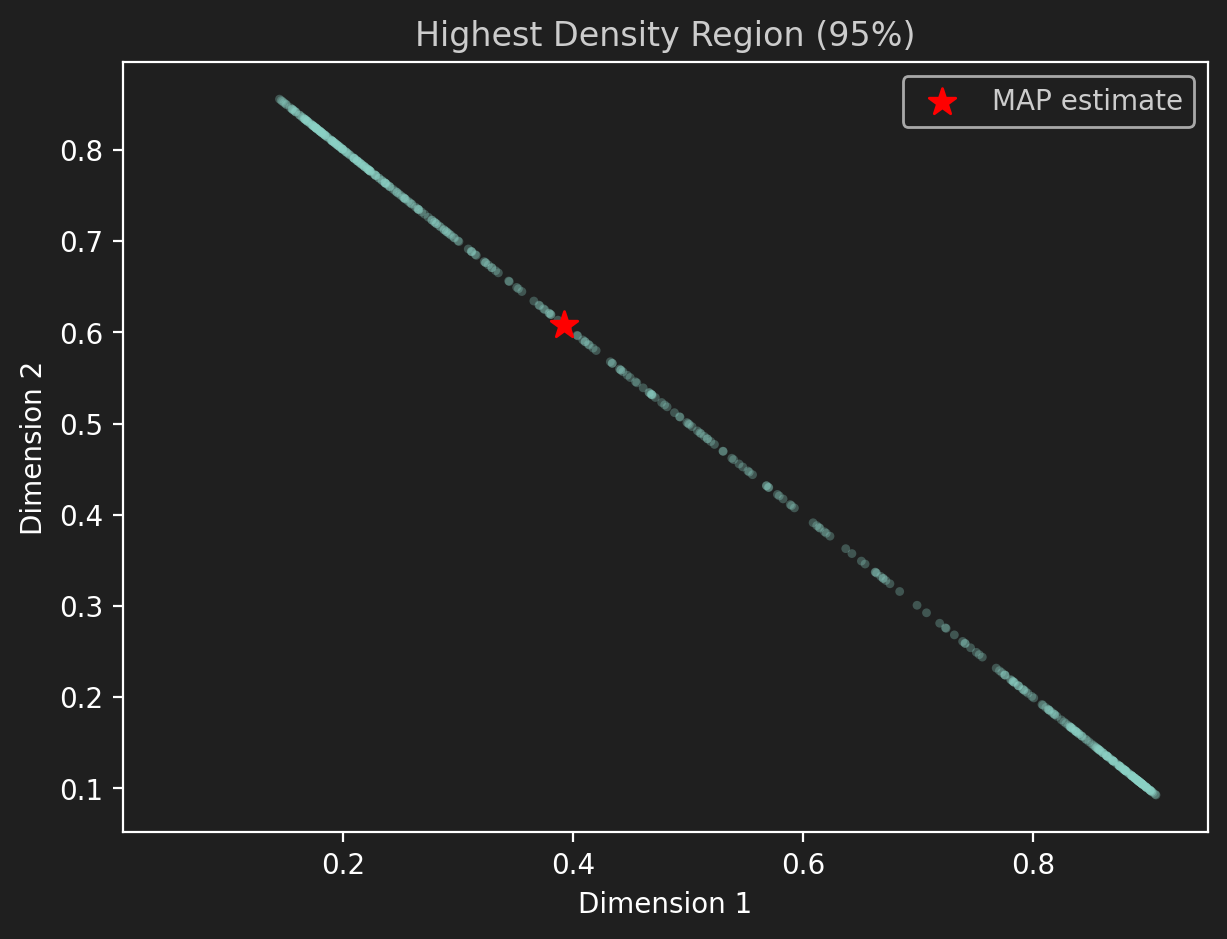

In [12]:


# Find MAP estimate
map_point, map_log_prob = map_estimate_from_particles(particles, logp)
print(f"MAP estimate: {map_point}, log probability: {map_log_prob}")

# # Refine with optimization
# refined_map, refined_log_prob = map_estimate_with_optimization(particles, logp)
# print(f"Refined MAP: {refined_map}, log probability: {refined_log_prob}")

# Get HDR
hdr_particles, threshold = estimate_hdr(particles, logp, alpha=0.95)
print(f"HDR contains {len(hdr_particles)} particles out of {len(particles)}")
print(f"HDR log probability threshold: {threshold}")

# Visualize HDR for 2D distribution
alphas=[
    # 0.8, 
    0.95, 
    # 0.99, 0.999
    ]

fig = visualize_hdr_2d(particles, logp, idx=[-2, -1], grid_size=5, alphas=alphas)
